In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, he_normal,he_uniform
import math

In [2]:
from sklearn.datasets import dump_svmlight_file
import numpy as np
import pandas as pd
import os
import urllib
import zipfile
from sklearn.model_selection import train_test_split
import shutil

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
model_name='model2ai'
seed=2020
embedding_init = RandomUniform(seed=seed)
relu_init = he_uniform(seed=seed)
embeddings_regu =l2(1e-6)
n_latent_factors = 16
loss_threshold = 0.5 #no scaler

In [4]:
from tensorflow.keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.5, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [5]:
datasets = {'ml100k':'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
            'ml20m':'http://files.grouplens.org/datasets/movielens/ml-20m.zip',
            'mllatestsmall':'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip',
            'ml10m':'http://files.grouplens.org/datasets/movielens/ml-10m.zip',
            'ml1m':'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
            }

In [6]:
print('Available datasets: ', [key for key in datasets])
dt = input('Dataset name = ')
print('You selected {}'.format(dt))

Available datasets:  ['ml100k', 'ml20m', 'mllatestsmall', 'ml10m', 'ml1m']
Dataset name = ml100k
You selected ml100k


In [11]:
# Download the file from `url` and save it locally under `file_name`:
dt_name = os.path.basename(datasets[dt])

print('Downloading {}'.format(dt_name))
with urllib.request.urlopen(datasets[dt]) as response, open('./sample_data/'+dt_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
print('Download completed')

Download completed


In [12]:
with zipfile.ZipFile('./sample_data/'+dt_name, 'r') as zip_ref:
    zip_ref.extractall('./sample_data/')
dt_dir_name = os.path.splitext(dt_name)[0]

In [7]:
def list_files(startpath):
    print(startpath)
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
dirs = [x[0] for x in os.walk("./sample_data")]
#print(list(dirs[0]))
ml = filter(lambda dirName: dirName if ('ml' in dirName) else '', list(dirs))
dt_dir_name= list(ml)[0]
print(dt_dir_name)
#list_files('./sample_data/'+dt_dir_name +'/')

./sample_data/ml-100k


In [8]:
# 100k 
if dt=='ml100k':
    dataset = pd.read_csv(dt_dir_name+"/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))
#ml1m
if dt=='ml1m':
    dataset=pd.read_csv(dt_dir_name +'/'+ 'ratings.dat', delimiter='\:\:', names=['user_id', 'item_id', 'rating', 'timestamp'])  
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [9]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [10]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(943, 1682)

In [11]:
#Version 1.2 (flexible + superfast negative sampling uniform)
import random
import time
import scipy

def neg_sampling(ratings_df, n_neg=1, neg_val=0, pos_val=1, percent_print=5):
    """version 1.2: 1 positive 1 neg (2 times bigger than the original dataset by default)

    Parameters:
    input rating data as pandas dataframe: userId|movieId|rating
    n_neg: include n_negative / 1 positive

    Returns:
    negative sampled set as pandas dataframe
            userId|movieId|interact (implicit)
    """
    sparse_mat = scipy.sparse.coo_matrix((ratings_df.rating, (ratings_df.user_id, ratings_df.item_id)))
    dense_mat = np.asarray(sparse_mat.todense())
    print(dense_mat.shape)

    nsamples = ratings_df[['user_id', 'item_id']]
    nsamples['rating'] = nsamples.apply(lambda row: 1, axis=1)
    length = dense_mat.shape[0]
    printpc = int(length * percent_print/100)

    nTempData = []
    i = 0
    start_time = time.time()
    stop_time = time.time()

    extra_samples = 0
    for row in dense_mat:
        if(i%printpc==0):
            stop_time = time.time()
            print("processed ... {0:0.2f}% ...{1:0.2f}secs".format(float(i)*100 / length, stop_time - start_time))
            start_time = stop_time

        n_non_0 = len(np.nonzero(row)[0])
        zero_indices = np.where(row==0)[0]
        if(n_non_0 * n_neg + extra_samples >= len(zero_indices)):
            print(i, "non 0:", n_non_0,": len ",len(zero_indices))
            neg_indices = zero_indices.tolist()
            extra_samples = n_non_0 * n_neg + extra_samples - len(zero_indices)
        else:
            neg_indices = random.sample(zero_indices.tolist(), n_non_0 * n_neg + extra_samples)
            extra_samples = 0

        nTempData.extend([(uu, ii, rr) for (uu, ii, rr) in zip(np.repeat(i, len(neg_indices))
                        , neg_indices, np.repeat(neg_val, len(neg_indices)))])
        i+=1

    nsamples=nsamples.append(pd.DataFrame(nTempData, columns=["user_id","item_id", "rating"]),ignore_index=True)
    nsamples.reset_index(drop=True)
    return nsamples

In [12]:
neg_dataset = neg_sampling(dataset)


train, test = train_test_split(neg_dataset, test_size=0.2, random_state=2020)
train, val = train_test_split(train, test_size=0.2, random_state=2020)

(943, 1682)
processed ... 0.00% ...0.00secs
processed ... 4.98% ...0.01secs
processed ... 9.97% ...0.01secs
processed ... 14.95% ...0.01secs
processed ... 19.94% ...0.01secs
processed ... 24.92% ...0.01secs
processed ... 29.90% ...0.01secs
processed ... 34.89% ...0.01secs
processed ... 39.87% ...0.01secs
processed ... 44.86% ...0.01secs
processed ... 49.84% ...0.01secs
processed ... 54.83% ...0.01secs
processed ... 59.81% ...0.01secs
processed ... 64.79% ...0.00secs
processed ... 69.78% ...0.01secs
processed ... 74.76% ...0.01secs
processed ... 79.75% ...0.01secs
processed ... 84.73% ...0.01secs
processed ... 89.71% ...0.01secs
processed ... 94.70% ...0.01secs
processed ... 99.68% ...0.01secs


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1, l1_l2
import math

In [14]:
def create_model(dataset, n_latent_factors=16, regularizer=1e-6, learning_rate=0.001):
    n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
    movie_input = keras.layers.Input(shape=[1], name='Item')
    movie_embedding = keras.layers.Embedding(n_movies, n_latent_factors,
                                             embeddings_initializer=embedding_init,
                                             embeddings_regularizer=l2(regularizer),
                                             embeddings_constraint='NonNeg',
                                             name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1], name='User')
    user_embedding = keras.layers.Embedding(n_users, n_latent_factors,
                                            embeddings_initializer=embedding_init,
                                            embeddings_regularizer=l2(regularizer),
                                            embeddings_constraint='NonNeg',
                                            name='User-Embedding')(user_input)
    user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

    concat = keras.layers.concatenate([movie_vec, user_vec])

    mlp = concat
    for i in range(3, -1, -1):
        if i == 0:
            mlp = Dense(8 ** i, activation='sigmoid', kernel_initializer='glorot_normal',
                        name="output")(mlp)
        else:
            mlp = Dense(8 * 2 ** i, activation='relu', kernel_initializer='he_uniform')(mlp)
            if i > 2:
                mlp = BatchNormalization()(mlp)
                mlp = Dropout(0.2)(mlp)

    model = Model(inputs=[user_input, movie_input], outputs=[mlp])

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

    model.summary()
    return model

In [15]:
model = create_model(neg_dataset)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 16)        26912       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 16)        15088       User[0][0]                       
______________________________________________________________________________________________

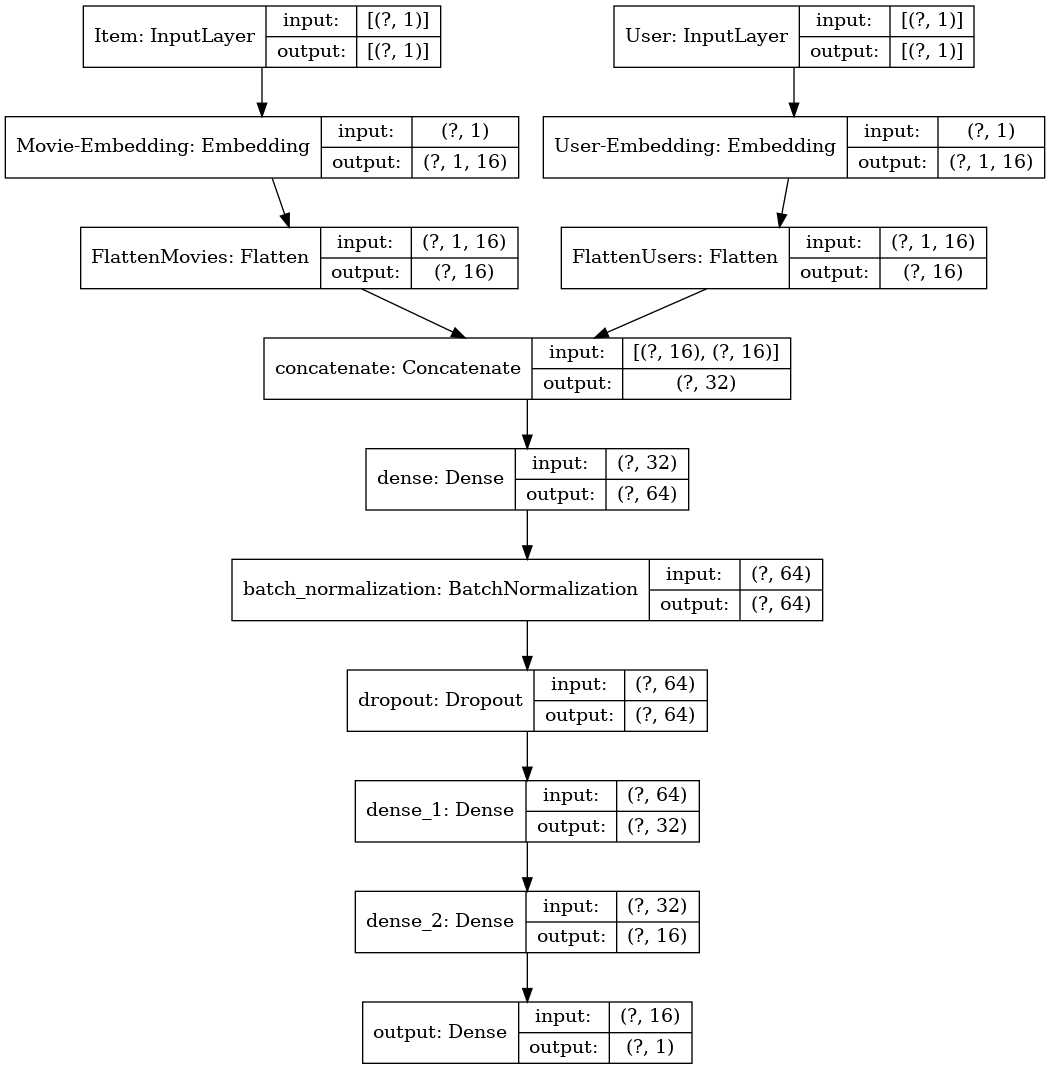

In [16]:
tf.keras.utils.plot_model(model, to_file= (model_name+".png") , show_shapes=True)

In [17]:
class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=16, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.dataframe = dataframe
        self.shuffle = shuffle
        self.indices = dataframe.index
        print(len(self.indices))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return math.floor(len(self.dataframe) / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        idxs = [i for i in range(index*self.batch_size,(index+1)*self.batch_size)]
        #print(idxs)
        # Find list of IDs
        list_IDs_temp = [self.indices[k] for k in idxs]

        # Generate data
        User = self.dataframe.iloc[list_IDs_temp,[0]].to_numpy().reshape(-1)
        Item = self.dataframe.iloc[list_IDs_temp,[1]].to_numpy().reshape(-1)
        rating = self.dataframe.iloc[list_IDs_temp,[2]].to_numpy().reshape(-1)
        #print("u,i,r:", [User, Item],[y])
        return [User, Item],[rating]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [18]:
train_generator = DataGenerator(train, batch_size=256, shuffle=False)
history = model.fit(train_generator, epochs=100,verbose=2)

128000
Epoch 1/100
500/500 - 3s - loss: 0.5322 - binary_accuracy: 0.7257
Epoch 2/100
500/500 - 3s - loss: 0.4769 - binary_accuracy: 0.7663
Epoch 3/100
500/500 - 3s - loss: 0.4667 - binary_accuracy: 0.7711
Epoch 4/100
500/500 - 3s - loss: 0.4582 - binary_accuracy: 0.7771
Epoch 5/100
500/500 - 3s - loss: 0.4378 - binary_accuracy: 0.7921
Epoch 6/100
500/500 - 3s - loss: 0.4157 - binary_accuracy: 0.8062
Epoch 7/100
500/500 - 3s - loss: 0.3972 - binary_accuracy: 0.8173
Epoch 8/100
500/500 - 3s - loss: 0.3828 - binary_accuracy: 0.8244
Epoch 9/100
500/500 - 3s - loss: 0.3727 - binary_accuracy: 0.8296
Epoch 10/100
500/500 - 3s - loss: 0.3630 - binary_accuracy: 0.8335
Epoch 11/100
500/500 - 3s - loss: 0.3561 - binary_accuracy: 0.8384
Epoch 12/100
500/500 - 3s - loss: 0.3498 - binary_accuracy: 0.8414
Epoch 13/100
500/500 - 3s - loss: 0.3451 - binary_accuracy: 0.8432
Epoch 14/100
500/500 - 3s - loss: 0.3391 - binary_accuracy: 0.8466
Epoch 15/100
500/500 - 3s - loss: 0.3350 - binary_accuracy: 0.84